<a href="https://colab.research.google.com/github/mlvlab/data303/blob/main/Image_Generation_by_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generative Adversarial Networks (GANs)
======

This example is derived from 1. 'Deep Learning for Graphics Tutorial'.

Resources:

1.  CreativeAI: Deep Learning for Graphics Tutorial [[Link]](https://github.com/smartgeometry-ucl/dl4g)
2.  debuggercafe.com [[Link]](https://debuggercafe.com/vanilla-gan-pytorch/)

# 0. Import Library + Utils

### Settings

In [ ]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

matplotlib.style.use('ggplot')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PATH = '/content/drive/MyDrive/Colab Notebooks/DATA303'

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Defining Some Utility Functions

In [ ]:
def count_param(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

# function to create the noise vector
def create_noise(sample_size, latent_dims):
    return torch.randn(sample_size, latent_dims,1,1).to(device)

# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

def plot_learning_curve(losses_g, losses_d):
    plt.ion()

    fig = plt.figure()
    plt.plot(losses_g, label='generator')
    plt.plot(losses_d, label='discriminator')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# interpolation of the two latent vectors
def interpolation(lambda1, model, latent_1, latent_2):
    with torch.no_grad():
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2 

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image.view(image_size*image_size, -1)

# 1. Learn a GAN (deconv) with 64x64

## Hyperparameter setting

In [ ]:
image_size = 64 # MNIST image size

latent_dims = 100
num_epochs = 50
batch_size = 512
#batch_size = 256 
learning_rate = 0.001
use_gpu = True

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Load Dataset

In [ ]:
img_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5,), std = (0.5,))
])

to_pil_image = transforms.ToPILImage()

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

data, target = next(iter(train_dataloader))
print(data.shape)
print(target.shape)

torch.Size([512, 1, 64, 64])
torch.Size([512])


## GAN Architecture - 1
Like DCGAN, we use CNNs for generator and discriminator, which generally outperform vanilla GANs with fully connected layers.

In [ ]:
class Generator(nn.Module):
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(latent_dims, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))
        x = x.view(x.size(0), 1, image_size, image_size)

        return x

class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x

generator = Generator(latent_dims).to(device)
discriminator = Discriminator().to(device)

print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

num_params_gen = count_param(generator)
num_params_disc = count_param(discriminator)
print('Number of parameters for generator: {:,} and discriminator: {:,}'.format(num_params_gen, num_params_disc))


##### GENERATOR #####
Generator(
  (deconv1): ConvTranspose2d(100, 800, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(800, 400, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(400, 200, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(200, 100, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(100, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (

## Train

In [ ]:
# loss criterion
criterion = nn.BCELoss()

# optimizer
optim_g = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optim_d = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()

losses_d = []
losses_g = []
images=[]

fixed_noise = create_noise(batch_size, latent_dims)

print('Training ...')

for epoch in range(num_epochs):
    loss_g = 0.0
    loss_d = 0.0

    
    for bi, data in tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = image.size(0)


        optim_d.zero_grad()
        label_real = torch.ones(b_size, device=device)
        label_fake = torch.zeros(b_size, device=device)

        # for real_images
        real_pred = discriminator(image).squeeze()
        d_loss_real = criterion(real_pred, label_real)
        d_loss_real.backward()

        # for fake images
        fake_image_batch = generator(create_noise(b_size,latent_dims)) # generator가 만들어낸 이미지 512개 
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()  
        d_loss_fake = criterion(fake_pred, label_fake)
        d_loss_fake.backward()

        loss_d += d_loss_real + d_loss_fake # 따로 backprop을 하는게 더 안정적으로 학습된다. real과 fake를 더 잘 학습함
        optim_d.step()
            
        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        g_loss = criterion(fake_pred, label_real)
        loss_g +=g_loss
        optim_g.zero_grad()
        g_loss.backward()
        optim_g.step()



    # create the final fake image for the epoch
    generated_img = generator(fixed_noise).cpu().detach() # to check the output of training
    generated_img = make_grid(generated_img) # make the images as grid


    save_generator_image(generated_img, f"{PATH}/1/images/gen_img{epoch}.png") # save the generated torch tensor models to disk
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    if (epoch+1)% 10==0:
      print(f"Epoch {epoch+1} of {num_epochs}")
      print(f"Generator loss: {epoch_loss_g:.6f}, Discriminator loss: {epoch_loss_d:.6f}")


Training ...


118it [00:27,  4.32it/s]
118it [00:27,  4.32it/s]                         
118it [00:27,  4.34it/s]                         
118it [00:26,  4.39it/s]                         
118it [00:27,  4.34it/s]                         
118it [00:27,  4.34it/s]                         
118it [00:27,  4.35it/s]                         
118it [00:26,  4.43it/s]                         
118it [00:25,  4.55it/s]                         
118it [00:26,  4.48it/s]                         


Epoch 10 of 50
Generator loss: 7.973573, Discriminator loss: 0.034639


118it [00:26,  4.53it/s]                         
118it [00:26,  4.52it/s]                         
118it [00:26,  4.51it/s]                         
118it [00:26,  4.46it/s]                         
118it [00:26,  4.41it/s]                         
118it [00:26,  4.52it/s]                         
118it [00:26,  4.43it/s]                         
118it [00:27,  4.36it/s]                         
118it [00:26,  4.47it/s]                         
118it [00:26,  4.53it/s]                         


Epoch 20 of 50
Generator loss: 3.525896, Discriminator loss: 0.666979


118it [00:25,  4.58it/s]                         
118it [00:25,  4.56it/s]                         
118it [00:26,  4.54it/s]                         
118it [00:26,  4.52it/s]                         
118it [00:25,  4.58it/s]                         
118it [00:25,  4.59it/s]                         
118it [00:25,  4.55it/s]                         
118it [00:25,  4.58it/s]                         
118it [00:25,  4.58it/s]                         
118it [00:25,  4.57it/s]                         


Epoch 30 of 50
Generator loss: 3.967046, Discriminator loss: 0.403625


118it [00:25,  4.54it/s]                         
118it [00:25,  4.55it/s]                         
118it [00:25,  4.55it/s]                         
118it [00:26,  4.47it/s]                         
118it [00:26,  4.43it/s]                         
118it [00:26,  4.50it/s]                         
118it [00:26,  4.51it/s]                         
118it [00:26,  4.50it/s]                         
118it [00:25,  4.58it/s]                         
118it [00:25,  4.69it/s]                         


Epoch 40 of 50
Generator loss: 6.903180, Discriminator loss: 0.542249


118it [00:24,  4.76it/s]                         
118it [00:24,  4.77it/s]                         
118it [00:24,  4.75it/s]                         
118it [00:24,  4.76it/s]                         
118it [00:24,  4.79it/s]                         
118it [00:24,  4.75it/s]                         
118it [00:24,  4.75it/s]                         
118it [00:24,  4.76it/s]                         
118it [00:24,  4.77it/s]                         
118it [00:24,  4.80it/s]                         


Epoch 50 of 50
Generator loss: 5.503644, Discriminator loss: 0.022582


In [ ]:
tmp_g =losses_g
tmp_d = losses_d

In [ ]:
print('DONE TRAINING')
print('z_100, lr 0.001, batch 512')

torch.save(generator.state_dict(), f'{PATH}/1/models/gen_z_100.pth')
torch.save(discriminator.state_dict(), f'{PATH}/1/models/dis_z_100.pth')

# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave(f'{PATH}/1/images/z_100.gif', imgs)

# plot and save the generator and discriminator loss
losses_g = [t.cpu().detach().numpy() for t in losses_g]
losses_d = [t.cpu().detach().numpy() for t in losses_d]

# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{PATH}/1/losses/z_100.png')

## Results

### lr: 0.01, 0.001, 0.0001

DONE TRAINING
lr : 0.01 batch_size : 512 latent dim : 100 


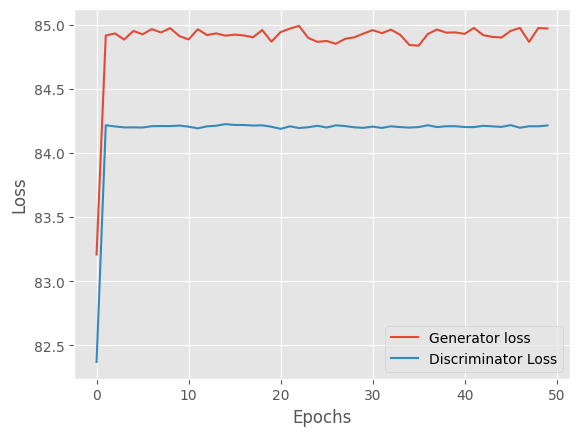

In [ ]:
## lr 0.01 

DONE TRAINING
z_100, lr 0.001, batch 512


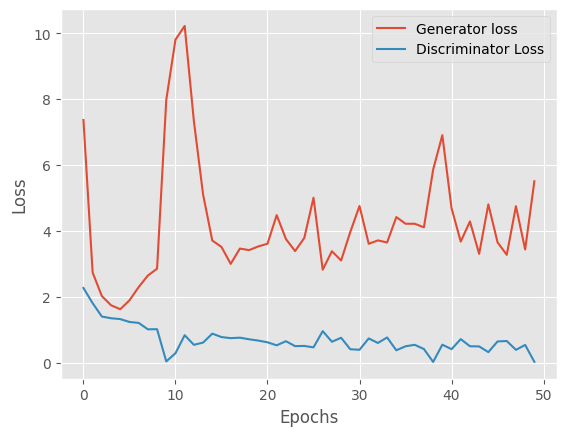

In [ ]:
### lr 0.001

DONE TRAINING


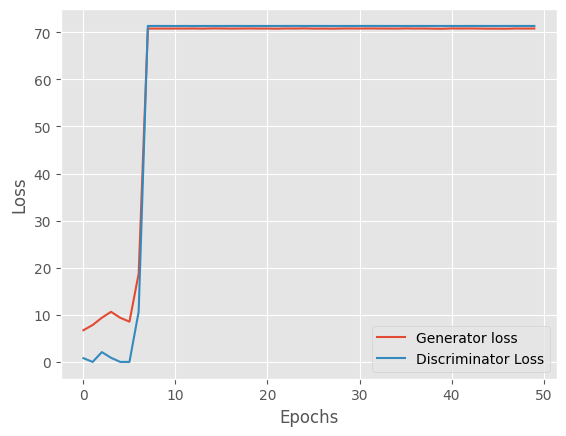

In [ ]:
## lr 0.0001



### latent_dim : 50, 100, 200

DONE TRAINING
z_50, lr 0.001, batch 512


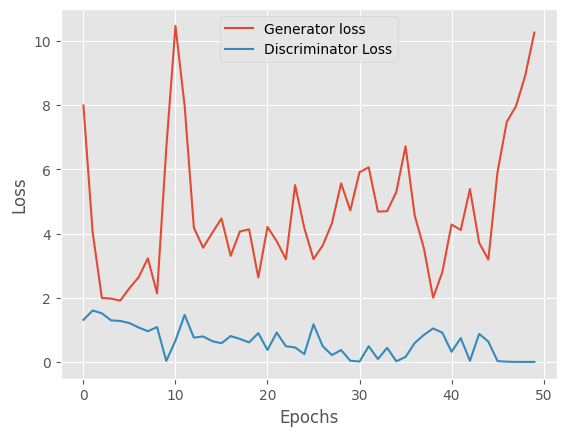

In [ ]:
### latent_dim 50

DONE TRAINING
z_100, lr 0.001, batch 512


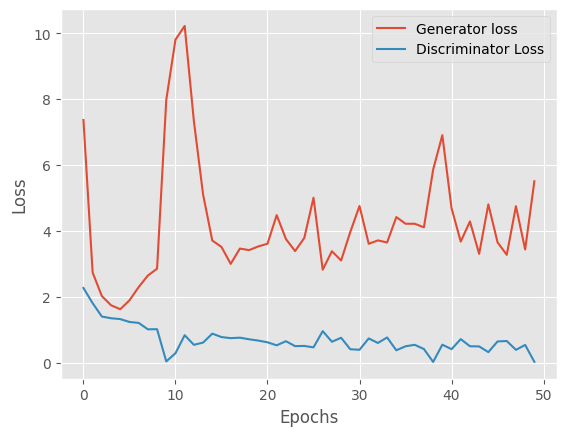

In [ ]:
### latent_dim 100

DONE TRAINING
z_200, lr 0.001, batch 512


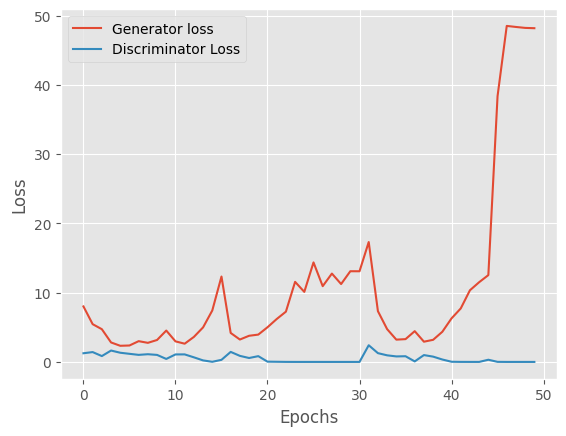

In [ ]:
### latent_dim 200

## Interpolate in Latent Space

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()
image_size=64
    
# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, 100, 1, 1, device=device)
latent_2 = torch.randn(1, 100, 1, 1, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,10)
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)
    inter_image = to_img(inter_image)
    image = inter_image.numpy()

    print(image.shape)

    #x = x.view(x.size(0), 1, image_size, image_size)
    #image = image.view(image_size,image_size)
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
    axs[ind].axis('off')
plt.show() 

# 2. Learn a GAN (deconv) with 28x28

## Hyperparameter Setting

In [ ]:
# learning parameters
batch_size = 512
num_epochs = 100
image_size = 28 
latent_dims = 100 
learning_rate = 2e-4
k = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Dataset

In [ ]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
image, label = next(iter(train_dataloader))
image.shape, label

## GAN Architecture - 2
Like DCGAN, we use CNNs for generator and discriminator, which generally outperform vanilla GANs with fully connected layers.

In [ ]:
class Generator(nn.Module):
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.latent_dims = latent_dims

        self.deconv1 = nn.ConvTranspose2d(latent_dims, d*4, 7, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*4)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        #self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        #self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv3 = nn.ConvTranspose2d(d*2, 1, 4, 2, 1)

    def forward(self, input):
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        #x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = torch.tanh(self.deconv3(x))

        return x 
     
class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, 1, 3, 1, 0)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = torch.sigmoid(self.conv4(x))

        return x
    
generator = Generator(latent_dims).to(device)
discriminator = Discriminator().to(device)

print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

num_params_gen = count_param(generator)
num_params_disc = count_param(discriminator)
print('Number of parameters for generator: {:,} and discriminator: {:,}'.format(num_params_gen, num_params_disc))

##### GENERATOR #####
Generator(
  (deconv1): ConvTranspose2d(100, 400, kernel_size=(7, 7), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(400, 200, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(200, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1, ker

## Train

In [ ]:
# loss criterion
criterion = nn.BCELoss()

# optimizer
optim_g = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optim_d = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()

losses_d = []
losses_g = []
images=[]

fixed_noise = create_noise(48 ,latent_dims)

In [ ]:
print('Training ...')

for epoch in range(num_epochs):
    losses_g.append(0)
    losses_d.append(0)
    num_batches = 0

    
    for bi, data in tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size)):
        # get dataset image and create real and fake labels for use in the loss
        image_batch, _ = data
        image_batch = image_batch.to(device)
        batch_size = image_batch.size(0)

        label_real = torch.ones(batch_size).to(device)
        label_fake = torch.zeros(batch_size).to(device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(batch_size, latent_dims, 1, 1).to(device)
        fake_image_batch = generator(latent)

        
          # train discriminator to correctly classify real and fake
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()  

        d_loss_real =  F.binary_cross_entropy(real_pred, label_real)
        d_loss_real.backward()

        d_loss_fake = F.binary_cross_entropy(fake_pred, label_fake)
        d_loss_fake.backward()

        d_loss = (d_loss_real + d_loss_fake) 

        optim_d.zero_grad()
        optim_d.step()


        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        g_loss =  F.binary_cross_entropy(fake_pred, label_real)
        #loss_g +=g_loss
        optim_g.zero_grad()
        g_loss.backward()
        optim_g.step()

        losses_g[-1] += g_loss.item()
        losses_d[-1] += d_loss.item()
        num_batches += 1

    losses_g[-1] /= num_batches
    losses_d[-1] /= num_batches  


    # create the final fake image for the epoch
    generated_img = generator(fixed_noise).cpu().detach() # to check the output of training
    generated_img = make_grid(generated_img) # make the images as grid

    save_generator_image(generated_img, f"{PATH}/2/images/gen_img{epoch}.png") # save the generated torch tensor models to disk
    images.append(generated_img)

    if (epoch+1)% 10==0:
      print(f"Epoch {epoch+1} of {num_epochs}")
      print(f"Generator loss: {losses_g[-1]:.6f}, Discriminator loss: {losses_d[-1]:.6f}")


Training ...


118it [01:04,  1.82it/s]                         
118it [00:59,  1.99it/s]                         
118it [01:00,  1.96it/s]                         
118it [01:00,  1.95it/s]                         
118it [01:01,  1.93it/s]                         
118it [01:01,  1.92it/s]                         
118it [01:01,  1.92it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         


Epoch 10 of 100
Generator loss: 0.000431, Discriminator loss: 8.587361


118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:02,  1.89it/s]                         
118it [01:01,  1.91it/s]                         


Epoch 20 of 100
Generator loss: 0.000194, Discriminator loss: 9.388734


118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:02,  1.90it/s]                         
118it [01:02,  1.90it/s]                         
118it [01:02,  1.90it/s]                         
118it [01:02,  1.90it/s]                         
118it [01:01,  1.90it/s]                         
118it [01:02,  1.90it/s]                         
118it [01:01,  1.90it/s]                         
118it [01:01,  1.91it/s]                         


Epoch 30 of 100
Generator loss: 0.000107, Discriminator loss: 9.984244


118it [01:01,  1.91it/s]                         
118it [01:02,  1.89it/s]                         
118it [01:01,  1.90it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         


Epoch 40 of 100
Generator loss: 0.000065, Discriminator loss: 10.483167


118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:01,  1.92it/s]                         
118it [01:01,  1.92it/s]                         
118it [01:01,  1.92it/s]                         
118it [01:01,  1.92it/s]                         
118it [01:01,  1.92it/s]                         


Epoch 50 of 100
Generator loss: 0.000045, Discriminator loss: 10.857241


118it [01:01,  1.92it/s]                         
118it [01:01,  1.92it/s]                         
118it [01:01,  1.92it/s]                         
118it [01:02,  1.88it/s]                         
118it [01:02,  1.90it/s]                         
118it [01:02,  1.89it/s]                         
118it [01:02,  1.88it/s]                         
118it [01:01,  1.90it/s]                         
118it [01:01,  1.90it/s]                         
118it [01:02,  1.90it/s]                         


Epoch 60 of 100
Generator loss: 0.000552, Discriminator loss: 8.336620


118it [01:02,  1.90it/s]                         
118it [01:02,  1.89it/s]                         
118it [01:02,  1.89it/s]                         
118it [01:02,  1.90it/s]                         
118it [01:02,  1.90it/s]                         
118it [01:01,  1.90it/s]                         
118it [01:01,  1.90it/s]                         
118it [01:01,  1.90it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         


Epoch 70 of 100
Generator loss: 0.000242, Discriminator loss: 9.163258


118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:01,  1.91it/s]                         
118it [01:01,  1.90it/s]                         
118it [01:02,  1.90it/s]                         
118it [01:02,  1.89it/s]                         
118it [01:02,  1.90it/s]                         
118it [01:02,  1.89it/s]                         
118it [01:02,  1.90it/s]                         


Epoch 80 of 100
Generator loss: 0.000153, Discriminator loss: 9.624183


118it [01:02,  1.89it/s]                         
118it [01:02,  1.90it/s]                         
118it [01:02,  1.89it/s]                         
118it [01:02,  1.89it/s]                         
118it [01:02,  1.89it/s]                         
118it [01:02,  1.89it/s]                         
118it [01:02,  1.89it/s]                         
118it [01:02,  1.89it/s]                         
118it [01:02,  1.89it/s]                         
118it [01:02,  1.90it/s]                         


Epoch 90 of 100
Generator loss: 0.000109, Discriminator loss: 9.958194


118it [01:02,  1.90it/s]                         
118it [01:02,  1.90it/s]                         
118it [01:02,  1.90it/s]                         
118it [01:02,  1.89it/s]                         
118it [01:02,  1.89it/s]                         
118it [01:02,  1.90it/s]                         
118it [01:01,  1.90it/s]                         
118it [01:02,  1.90it/s]                         
118it [01:02,  1.90it/s]                         
118it [01:02,  1.90it/s]                         


Epoch 100 of 100
Generator loss: 0.000072, Discriminator loss: 10.376075


In [ ]:
tmp_d, tmp_g = losses_d, losses_g

In [ ]:
print('DONE TRAINING')
print('lr 2e-4 z 100 batch 512 k=4')

torch.save(generator.state_dict(), f'{PATH}/2/models/gen_lr_2e-4_k_4.pth')
torch.save(discriminator.state_dict(), f'{PATH}/2/models/dis_lr_2e-4_k_4.pth')

# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave(f'{PATH}/2/images/lr_2e-4_k_4.gif', imgs)

# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{PATH}/2/losses/lr_2e-4_k_4.png')

## Results


### k = 1,2

DONE TRAINING
lr 2e-4 z 100 batch 512 k=1


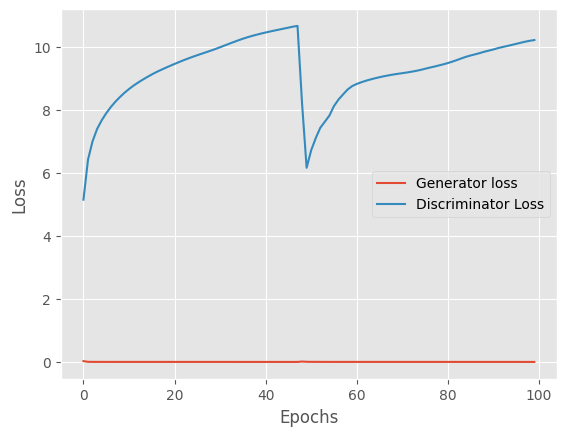

In [ ]:
## k=1

DONE TRAINING
lr 2e-4 z 100 batch 512 k=2


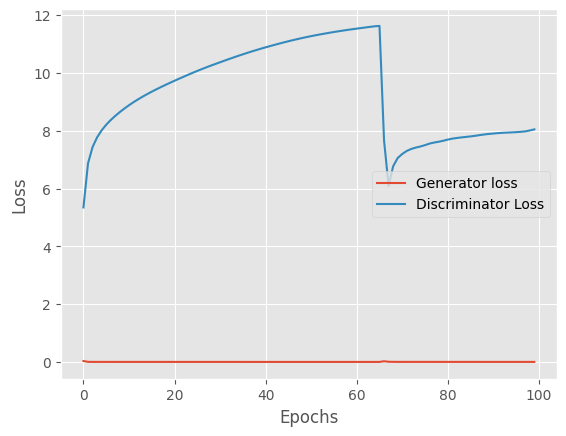

In [ ]:
## k=2

### lr : 0.001, 2e-4


DONE TRAINING
lr 0.001 z 100 batch 512


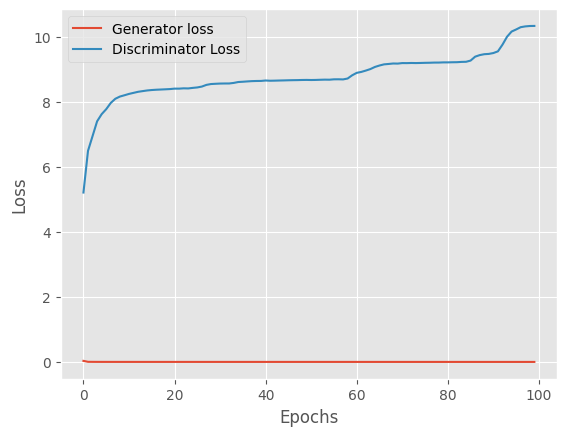

In [ ]:
## k=1 lr 0.001

DONE TRAINING
lr 2e-4 z 100 batch 512 k=1


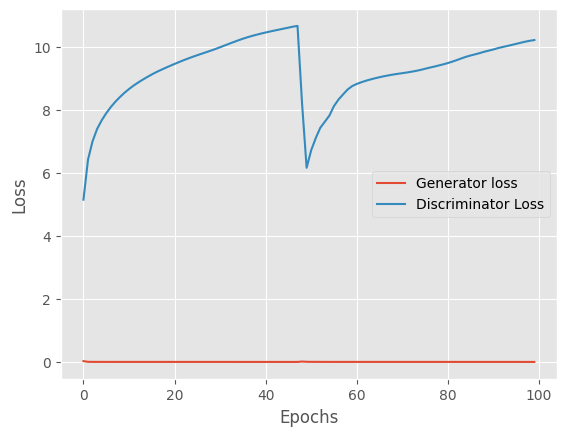

In [ ]:
## k=2e-4

## Interpolate in Latent Space

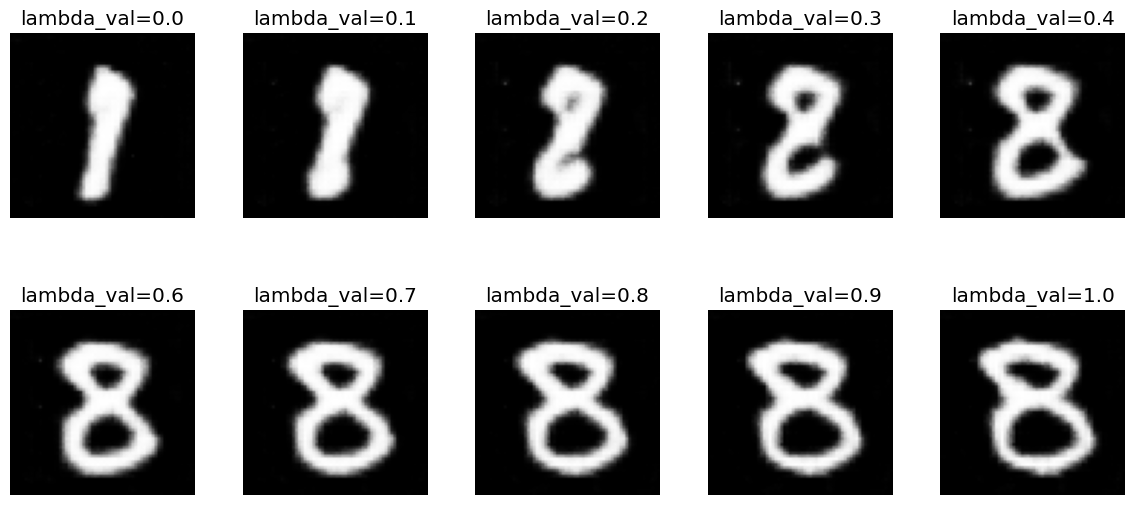

# 3. Learn a GAN (MLP)

## Hyperparameter setting

In [ ]:
sample_size = 28 # fixed sample size

latent_dims = 50
num_epochs = 100
batch_size = 512
#batch_size = 128
k=1
learning_rate = 0.001

## Load Dataset

In [ ]:
img_transform = transforms.Compose([
    transforms.Resize(sample_size),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5,), std = (0.5,))
])

to_pil_image = transforms.ToPILImage()

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## GAN Architecture - 3 
Vanilla GAN

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dims ,d=128):
        super(Generator, self).__init__()

        self.latent_dims = latent_dims
        self.main = nn.Sequential(
            nn.Linear(self.latent_dims, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, sample_size*sample_size), # 784
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1, sample_size, sample_size)

class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.n_input = sample_size*sample_size  # flatten size of input = 784

        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),  # output: scalar
            nn.Sigmoid()
        )

    def forward(self, input):
        input = input.view(-1, sample_size*sample_size)
        return self.main(input)
    
    
generator = Generator(latent_dims).to(device)
discriminator = Discriminator().to(device)

print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

num_params_gen = count_param(generator)
num_params_disc = count_param(discriminator)
print('Number of parameters for generator: {:,} and discriminator: {:,}'.format(num_params_gen, num_params_disc))

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=50, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1,

## Train

In [ ]:
# loss criterion
criterion = nn.BCELoss()

# optimizer
optim_g = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optim_d = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()


#create the noise vector that we will need to generate the fake data using the generator
fixed_noise = create_noise(sample_size, latent_dims)

Train function

In [ ]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0) # batch size of the data
    real_label = label_real(b_size) # create the real labels
    fake_label = label_fake(b_size) # create the fake labels

    optimizer.zero_grad()

    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)

    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)

    loss_real.backward()
    loss_fake.backward()

    optimizer.step()

    return loss_real + loss_fake # d_loss = loss_real + loss_fake


# function to train the generator network
def train_generator(optimizer, data_fake):

    b_size = data_fake.size(0) # batch size of the data
    real_label = label_real(b_size) # create the real labels

    optimizer.zero_grad()

    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss # g_loss

Training loop

In [ ]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator


print('Training ...')

for epoch in range(num_epochs):
    loss_g = 0.0
    loss_d = 0.0
    
    #for image_batch, _ in train_dataloader:

    for bi, data in tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)

        # train discriminator for k steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, latent_dims)).detach() # batch of fake, generated images
            data_real = image # batch of real images
            
            loss_d += train_discriminator(optim_d, data_real, data_fake) # train the discriminator network

        # train the generator network
        data_fake = generator(create_noise(b_size, latent_dims))
        loss_g += train_generator(optim_g, data_fake)



    # create the final fake image for the epoch
    generated_img = generator(fixed_noise).cpu().detach()
    generated_img = make_grid(generated_img) # make the images as grid

    
    save_generator_image(generated_img, f"{PATH}/3/images/gen_img{epoch}.png") # save the generated torch tensor models to disk
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    #if (epoch+1)%10==0:
    print(f"Epoch {epoch+1} of {num_epochs}")
    print(f"Generator loss: {epoch_loss_g:.6f}, Discriminator loss: {epoch_loss_d:.6f}")


Training ...


118it [00:18,  6.30it/s]                         


Epoch 1 of 100
Generator loss: 0.765441, Discriminator loss: 1.428699


118it [00:20,  5.81it/s]                         


Epoch 2 of 100
Generator loss: 0.768306, Discriminator loss: 1.406171


118it [00:20,  5.74it/s]                         


Epoch 3 of 100
Generator loss: 0.795177, Discriminator loss: 1.355280


118it [00:21,  5.42it/s]                         


Epoch 4 of 100
Generator loss: 0.878148, Discriminator loss: 1.323605


118it [00:21,  5.49it/s]                         


Epoch 5 of 100
Generator loss: 0.865126, Discriminator loss: 1.307735


118it [00:20,  5.73it/s]                         


Epoch 6 of 100
Generator loss: 0.871840, Discriminator loss: 1.329468


118it [00:20,  5.79it/s]                         


Epoch 7 of 100
Generator loss: 0.848770, Discriminator loss: 1.334091


118it [00:20,  5.80it/s]                         


Epoch 8 of 100
Generator loss: 0.861478, Discriminator loss: 1.322873


118it [00:20,  5.87it/s]                         


Epoch 9 of 100
Generator loss: 0.876666, Discriminator loss: 1.322042


118it [00:19,  5.97it/s]                         


Epoch 10 of 100
Generator loss: 0.910314, Discriminator loss: 1.302433


118it [00:19,  6.03it/s]                         


Epoch 11 of 100
Generator loss: 0.918284, Discriminator loss: 1.307994


118it [00:19,  6.20it/s]                         


Epoch 12 of 100
Generator loss: 0.899275, Discriminator loss: 1.341723


118it [00:19,  6.19it/s]                         


Epoch 13 of 100
Generator loss: 0.875153, Discriminator loss: 1.343953


118it [00:18,  6.22it/s]                         


Epoch 14 of 100
Generator loss: 0.866703, Discriminator loss: 1.376767


118it [00:18,  6.46it/s]                         


Epoch 15 of 100
Generator loss: 0.914138, Discriminator loss: 1.315514


118it [00:18,  6.48it/s]                         


Epoch 16 of 100
Generator loss: 0.949938, Discriminator loss: 1.289886


118it [00:17,  6.66it/s]                         


Epoch 17 of 100
Generator loss: 0.919402, Discriminator loss: 1.334538


118it [00:17,  6.75it/s]                         


Epoch 18 of 100
Generator loss: 0.876347, Discriminator loss: 1.344696


118it [00:17,  6.72it/s]                         


Epoch 19 of 100
Generator loss: 0.911207, Discriminator loss: 1.321754


118it [00:17,  6.75it/s]                         


Epoch 20 of 100
Generator loss: 0.924562, Discriminator loss: 1.316122


118it [00:17,  6.77it/s]                         


Epoch 21 of 100
Generator loss: 0.947093, Discriminator loss: 1.284968


118it [00:17,  6.79it/s]                         


Epoch 22 of 100
Generator loss: 0.948357, Discriminator loss: 1.288284


118it [00:17,  6.77it/s]                         


Epoch 23 of 100
Generator loss: 0.970620, Discriminator loss: 1.289714


118it [00:17,  6.61it/s]                         


Epoch 24 of 100
Generator loss: 0.974890, Discriminator loss: 1.277624


118it [00:17,  6.66it/s]                         


Epoch 25 of 100
Generator loss: 0.954686, Discriminator loss: 1.301217


118it [00:17,  6.62it/s]                         


Epoch 26 of 100
Generator loss: 0.937885, Discriminator loss: 1.281555


118it [00:17,  6.76it/s]                         


Epoch 27 of 100
Generator loss: 0.897362, Discriminator loss: 1.330403


118it [00:17,  6.68it/s]                         


Epoch 28 of 100
Generator loss: 0.930084, Discriminator loss: 1.285767


118it [00:17,  6.75it/s]                         


Epoch 29 of 100
Generator loss: 0.944894, Discriminator loss: 1.276563


118it [00:17,  6.68it/s]                         


Epoch 30 of 100
Generator loss: 0.933638, Discriminator loss: 1.290812


118it [00:17,  6.67it/s]                         


Epoch 31 of 100
Generator loss: 0.928641, Discriminator loss: 1.294561


118it [00:17,  6.81it/s]                         


Epoch 32 of 100
Generator loss: 0.933488, Discriminator loss: 1.289673


118it [00:18,  6.55it/s]                         


Epoch 33 of 100
Generator loss: 0.908754, Discriminator loss: 1.302129


118it [00:17,  6.56it/s]                         


Epoch 34 of 100
Generator loss: 0.907859, Discriminator loss: 1.301165


118it [00:18,  6.55it/s]                         


Epoch 35 of 100
Generator loss: 0.893918, Discriminator loss: 1.310324


118it [00:17,  6.89it/s]                         


Epoch 36 of 100
Generator loss: 0.890322, Discriminator loss: 1.309663


118it [00:17,  6.73it/s]                         


Epoch 37 of 100
Generator loss: 0.870764, Discriminator loss: 1.328588


118it [00:17,  6.86it/s]                         


Epoch 38 of 100
Generator loss: 0.866180, Discriminator loss: 1.329413


118it [00:17,  6.72it/s]                         


Epoch 39 of 100
Generator loss: 0.870386, Discriminator loss: 1.323017


118it [00:17,  6.82it/s]                         


Epoch 40 of 100
Generator loss: 0.861790, Discriminator loss: 1.333049


118it [00:17,  6.77it/s]                         


Epoch 41 of 100
Generator loss: 0.852194, Discriminator loss: 1.333982


118it [00:17,  6.70it/s]                         


Epoch 42 of 100
Generator loss: 0.843928, Discriminator loss: 1.339671


118it [00:17,  6.76it/s]                         


Epoch 43 of 100
Generator loss: 0.837004, Discriminator loss: 1.346151


118it [00:17,  6.79it/s]                         


Epoch 44 of 100
Generator loss: 0.831695, Discriminator loss: 1.347703


118it [00:17,  6.83it/s]                         


Epoch 45 of 100
Generator loss: 0.826951, Discriminator loss: 1.349749


118it [00:17,  6.76it/s]                         


Epoch 46 of 100
Generator loss: 0.820010, Discriminator loss: 1.353400


118it [00:17,  6.70it/s]                         


Epoch 47 of 100
Generator loss: 0.824216, Discriminator loss: 1.352216


118it [00:17,  6.74it/s]                         


Epoch 48 of 100
Generator loss: 0.812036, Discriminator loss: 1.358330


118it [00:18,  6.41it/s]                         


Epoch 49 of 100
Generator loss: 0.816567, Discriminator loss: 1.357904


118it [00:17,  6.58it/s]                         


Epoch 50 of 100
Generator loss: 0.808051, Discriminator loss: 1.367035


118it [00:17,  6.59it/s]                         


Epoch 51 of 100
Generator loss: 0.797218, Discriminator loss: 1.365508


118it [00:17,  6.58it/s]                         


Epoch 52 of 100
Generator loss: 0.813670, Discriminator loss: 1.361792


118it [00:17,  6.64it/s]                         


Epoch 53 of 100
Generator loss: 0.806565, Discriminator loss: 1.364163


118it [00:17,  6.60it/s]                         


Epoch 54 of 100
Generator loss: 0.797094, Discriminator loss: 1.368269


118it [00:17,  6.62it/s]                         


Epoch 55 of 100
Generator loss: 0.796496, Discriminator loss: 1.367087


118it [00:17,  6.63it/s]                         


Epoch 56 of 100
Generator loss: 0.799758, Discriminator loss: 1.366697


118it [00:17,  6.60it/s]                         


Epoch 57 of 100
Generator loss: 0.799702, Discriminator loss: 1.369085


118it [00:17,  6.70it/s]                         


Epoch 58 of 100
Generator loss: 0.796444, Discriminator loss: 1.370974


118it [00:17,  6.67it/s]                         


Epoch 59 of 100
Generator loss: 0.789558, Discriminator loss: 1.371324


118it [00:17,  6.56it/s]                         


Epoch 60 of 100
Generator loss: 0.795013, Discriminator loss: 1.370124


118it [00:17,  6.64it/s]                         


Epoch 61 of 100
Generator loss: 0.787655, Discriminator loss: 1.376362


118it [00:17,  6.60it/s]                         


Epoch 62 of 100
Generator loss: 0.788218, Discriminator loss: 1.372976


118it [00:17,  6.75it/s]                         


Epoch 63 of 100
Generator loss: 0.791777, Discriminator loss: 1.372465


118it [00:17,  6.58it/s]                         


Epoch 64 of 100
Generator loss: 0.784297, Discriminator loss: 1.378550


118it [00:17,  6.74it/s]                         


Epoch 65 of 100
Generator loss: 0.765447, Discriminator loss: 1.391899


118it [00:17,  6.67it/s]                         


Epoch 66 of 100
Generator loss: 0.777499, Discriminator loss: 1.377667


118it [00:17,  6.72it/s]                         


Epoch 67 of 100
Generator loss: 0.786196, Discriminator loss: 1.377125


118it [00:18,  6.52it/s]                         


Epoch 68 of 100
Generator loss: 0.783094, Discriminator loss: 1.374701


118it [00:17,  6.61it/s]                         


Epoch 69 of 100
Generator loss: 0.778657, Discriminator loss: 1.380783


118it [00:17,  6.57it/s]                         


Epoch 70 of 100
Generator loss: 0.777335, Discriminator loss: 1.379776


118it [00:17,  6.67it/s]                         


Epoch 71 of 100
Generator loss: 0.770794, Discriminator loss: 1.384363


118it [00:17,  6.80it/s]                         


Epoch 72 of 100
Generator loss: 0.776124, Discriminator loss: 1.380107


118it [00:17,  6.61it/s]                         


Epoch 73 of 100
Generator loss: 0.784983, Discriminator loss: 1.377211


118it [00:17,  6.76it/s]                         


Epoch 74 of 100
Generator loss: 0.767243, Discriminator loss: 1.390653


118it [00:17,  6.65it/s]                         


Epoch 75 of 100
Generator loss: 0.776165, Discriminator loss: 1.379691


118it [00:17,  6.74it/s]                         


Epoch 76 of 100
Generator loss: 0.770964, Discriminator loss: 1.385559


118it [00:18,  6.55it/s]                         


Epoch 77 of 100
Generator loss: 0.767858, Discriminator loss: 1.387062


118it [00:17,  6.65it/s]                         


Epoch 78 of 100
Generator loss: 0.772358, Discriminator loss: 1.385491


118it [00:17,  6.68it/s]                         


Epoch 79 of 100
Generator loss: 0.767843, Discriminator loss: 1.383679


118it [00:17,  6.76it/s]                         


Epoch 80 of 100
Generator loss: 0.773218, Discriminator loss: 1.384997


118it [00:17,  6.73it/s]                         


Epoch 81 of 100
Generator loss: 0.769563, Discriminator loss: 1.387416


118it [00:17,  6.72it/s]                         


Epoch 82 of 100
Generator loss: 0.775542, Discriminator loss: 1.382238


118it [00:17,  6.68it/s]                         


Epoch 83 of 100
Generator loss: 0.777700, Discriminator loss: 1.382828


118it [00:17,  6.74it/s]                         


Epoch 84 of 100
Generator loss: 0.776991, Discriminator loss: 1.382456


118it [00:17,  6.74it/s]                         


Epoch 85 of 100
Generator loss: 0.768861, Discriminator loss: 1.385599


118it [00:17,  6.76it/s]                         


Epoch 86 of 100
Generator loss: 0.776038, Discriminator loss: 1.381743


118it [00:17,  6.72it/s]                         


Epoch 87 of 100
Generator loss: 0.774171, Discriminator loss: 1.384772


118it [00:17,  6.68it/s]                         


Epoch 88 of 100
Generator loss: 0.766130, Discriminator loss: 1.383318


118it [00:17,  6.75it/s]                         


Epoch 89 of 100
Generator loss: 0.772390, Discriminator loss: 1.384390


118it [00:17,  6.76it/s]                         


Epoch 90 of 100
Generator loss: 0.773362, Discriminator loss: 1.382346


118it [00:17,  6.60it/s]                         


Epoch 91 of 100
Generator loss: 0.774001, Discriminator loss: 1.384215


118it [00:17,  6.72it/s]                         


Epoch 92 of 100
Generator loss: 0.770565, Discriminator loss: 1.384682


118it [00:17,  6.71it/s]                         


Epoch 93 of 100
Generator loss: 0.770774, Discriminator loss: 1.384211


118it [00:17,  6.65it/s]                         


Epoch 94 of 100
Generator loss: 0.761368, Discriminator loss: 1.386699


118it [00:17,  6.69it/s]                         


Epoch 95 of 100
Generator loss: 0.773525, Discriminator loss: 1.381684


118it [00:17,  6.75it/s]                         


Epoch 96 of 100
Generator loss: 0.761647, Discriminator loss: 1.388200


118it [00:17,  6.75it/s]                         


Epoch 97 of 100
Generator loss: 0.772682, Discriminator loss: 1.380413


118it [00:17,  6.72it/s]                         


Epoch 98 of 100
Generator loss: 0.431077, Discriminator loss: 46.112534


118it [00:17,  6.85it/s]                         


Epoch 99 of 100
Generator loss: 0.000000, Discriminator loss: 100.854706


118it [00:17,  6.80it/s]                         

Epoch 100 of 100
Generator loss: 0.000000, Discriminator loss: 100.854706


In [ ]:
tmp_g ,tmp_d = losses_g, losses_d

In [ ]:
print('DONE TRAINING')
print('lr 0.01\n*latent_dims 50*\nbatch_size 512')
torch.save(generator.state_dict(), f'{PATH}/3/models/gen_nz_50.pth')
torch.save(discriminator.state_dict(), f'{PATH}/3/models/dis_nz_50.pth')

# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave(f'{PATH}/3/images/nz_50.gif', imgs)

# plot and save the generator and discriminator loss
losses_g = [t.cpu().detach().numpy() for t in losses_g]
losses_d = [t.cpu().detach().numpy() for t in losses_d]

plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{PATH}/3/losses/nz_50.png')

## Results

#### latent_dim test : 100, 200, 50

latent_dim : 100

DONE TRAINING
*lr 0.001*
latent_dims 100
batch_size 512


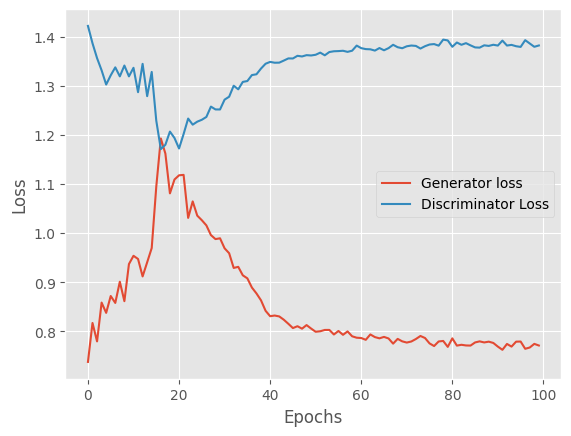

latent_dim : 200

DONE TRAINING
lr 0.01
*latent_dims 200*
batch_size 512


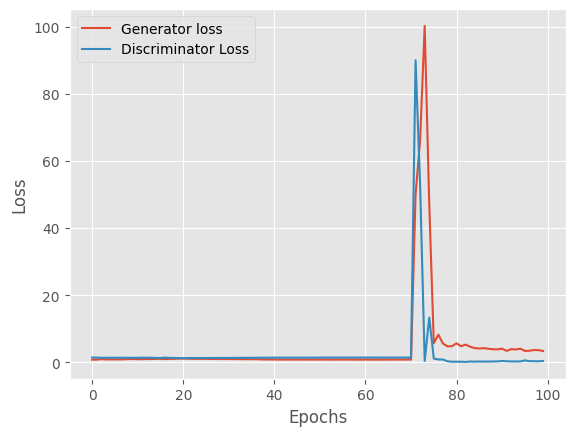

latent_dim : 50

DONE TRAINING
lr 0.01
*latent_dims 50*
batch_size 512


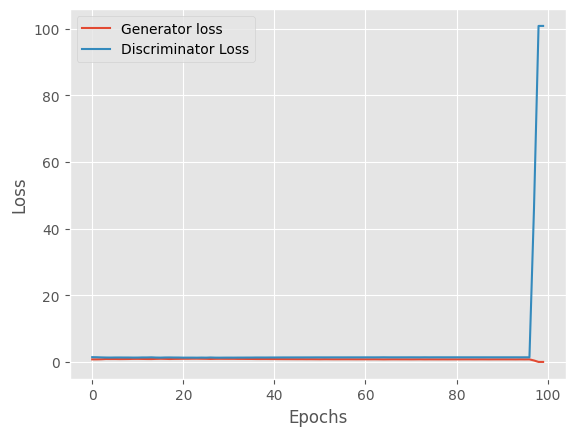

#### lr test: 0.01, 0.001, 0.0001

lr: 0.01

DONE TRAINING
*lr 0.01*
latent_dims 100
batch_size 512


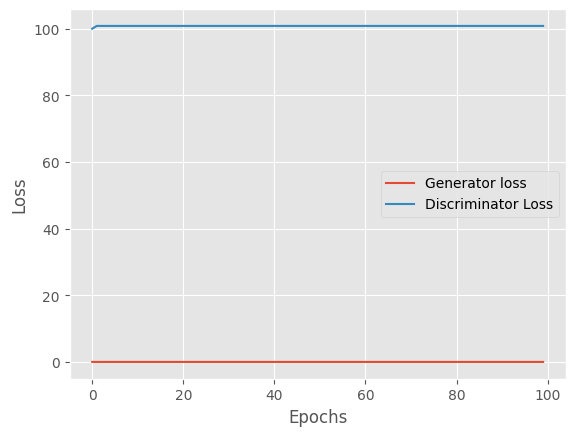

In [ ]:
### 0.01

lr : 0.001 

DONE TRAINING
*lr 0.001*
latent_dims 100
batch_size 512


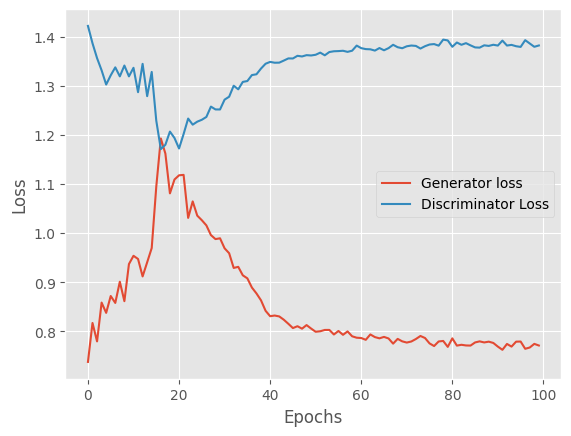

In [ ]:
#### lr_0.001

lr : 0.0001

DONE TRAINING
*lr 0.0001*
latent_dims 100
batch_size 512


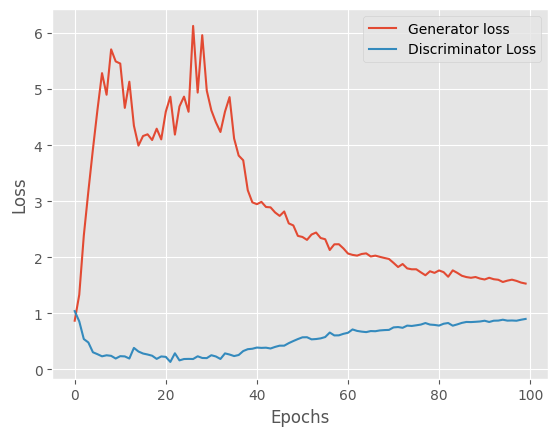

In [ ]:
### 0.0001

## Interpolate in Latent Space

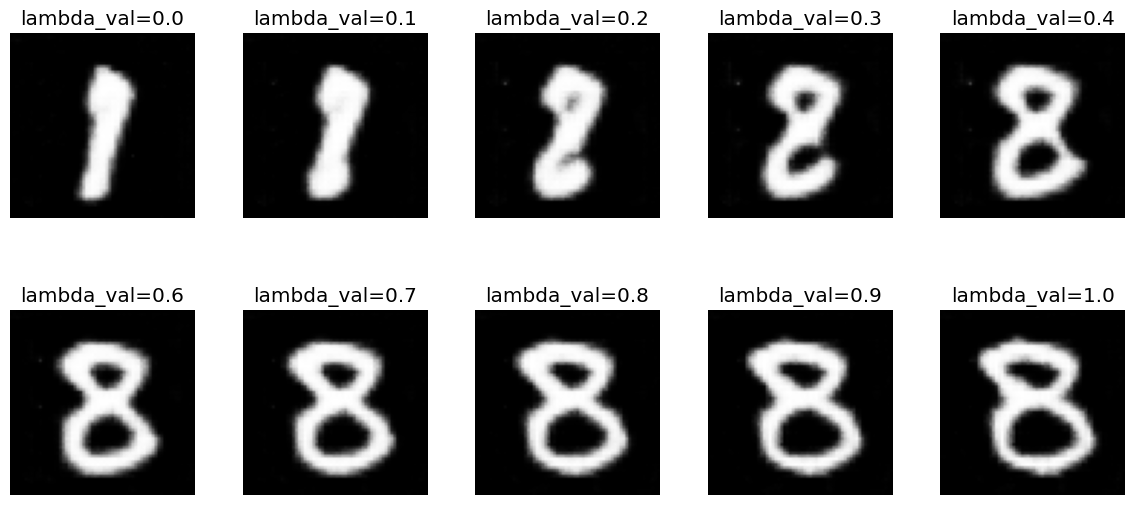

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()
    
# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, 100, 1, 1, device=device)
latent_2 = torch.randn(1, 100, 1, 1, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
    axs[ind].axis('off')
plt.show() 

# 4. Learn Info GAN

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
learning_rate = 2e-4
batch_size = 512
num_epochs = 100

z_dim = 16
c_dim = 10

image_size = 28*28

## Utilize Functions

In [ ]:
def weights_init(m):
    if (type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif (type(m) == nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


def noise_sample(n_dis_c, dis_c_dim, n_con_c, n_z, batch_size, device):

    z = torch.randn(batch_size, n_z, 1, 1, device=device)

    idx = np.zeros((n_dis_c, batch_size))

    if (n_dis_c != 0):
        dis_c = torch.zeros(batch_size, n_dis_c, dis_c_dim, device=device)

        for i in range(n_dis_c):
            idx[i] = np.random.randint(dis_c_dim, size=batch_size)
            dis_c[torch.arange(0, batch_size), i, idx[i]] = 1.0

        dis_c = dis_c.view(batch_size, -1, 1, 1)

    if (n_con_c != 0):
        # Random uniform between -1 and 1.
        con_c = torch.rand(batch_size, n_con_c, 1, 1, device=device) * 2 - 1

    noise = z
    if (n_dis_c != 0):
        noise = torch.cat((z, dis_c), dim=1)
    if (n_con_c != 0):
        noise = torch.cat((noise, con_c), dim=1)

    return noise, idx


class NormalNLLLoss:

    def __call__(self, x, mu, var):
        logli = -0.5 * (var.mul(2 * np.pi) + 1e-6).log() - (x - mu).pow(2).div(var.mul(2.0) + 1e-6)
        nll = -(logli.sum(1).mean())

        return nll

## Load dataset

In [ ]:
dataset = MNIST('./dataset', transform=transforms.ToTensor(), download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

## model architecture

### shared net

In [ ]:
class sharedNet(nn.Module): # G, Q 공통
    def __init__(self):
        super(sharedNet, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(128, 1024, 7, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),
        )

    def forward(self, input):
        output = self.main(input)
        return output

### Generator

In [ ]:
# Define the Generator network

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #self.z_dims = z_dims
        #self.c_con_dims = c_con_dims
        #self.c_cat_dims = c_cat_dims
        self.main = nn.Sequential(
            nn.ConvTranspose2d(74, 1024, 1, 1, bias=False), # 62+10+2 = z_dims + c_cat_dims + c_con_dims
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),
            nn.ConvTranspose2d(1024, 128, 7, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.ConvTranspose2d(64, 1, 4, 2, padding=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):   
        output = self.main(input)
        return output


### Discriminator


In [ ]:
# Define the Discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1024, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output

### Q_head

In [ ]:
# Define the Q network for estimating the latent codes
class Q(nn.Module):
    def __init__(self):
        super(Q, self).__init__()
        self.conv = nn.Conv2d(1024, 128, 1, bias=False)
        self.bn = nn.BatchNorm2d(128)
        self.lReLU = nn.LeakyReLU(0.1, inplace=True)
        self.conv_disc = nn.Conv2d(128, 10, 1)
        self.conv_mu = nn.Conv2d(128, 2, 1)
        self.conv_var = nn.Conv2d(128, 2, 1)

    def forward(self, input):
      
        x = F.leaky_relu(self.bn(self.conv(input)), 0.1, inplace=True)
        disc_logits = self.conv_disc(x).squeeze()

        mu = self.conv_mu(x).squeeze()
        var = torch.exp(self.conv_var(x).squeeze())

        return disc_logits, mu, var

## Train

### model define

In [ ]:
# model define
G = Generator()
D = Discriminator()
Q = Q()
SharedNet = sharedNet()

G.to(device)
D.to(device)
Q.to(device)
SharedNet.to(device)

G.apply(weights_init)
D.apply(weights_init)
Q.apply(weights_init)
SharedNet.apply(weights_init)


print('##### GENERATOR #####')
print(G)
print('######################')
print('##### DISCRIMINATOR #####')
print(D)
print('######################')
print('##### Q_NN #####')
print(Q)
print('######################')
print('##### SHAREDNET #####')
print(SharedNet)
print('######################')
num_params_g = count_param(G)
num_params_d = count_param(D)
num_params_q = count_param(Q)
num_params_s = count_param(SharedNet)
print('Number of parameters\ngenerator: {:,}\ndiscriminator: {:,}\nQ_network: {:,}\nSharedNet: {:,}\n'.format(num_params_g, num_params_d,num_params_q,num_params_s))


##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(74, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): ConvTranspose2d(1024, 128, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1, inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Sigmoid()
  )
)
######################
##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Conv2d(1024, 1, kernel_size=(1, 1), st

### variable define

In [ ]:
real_x = torch.FloatTensor(batch_size, 1, 28, 28).to(device)
label = torch.FloatTensor(batch_size, 1).to(device)
n_dis_c = torch.FloatTensor(batch_size, 1).to(device)
dis_c = torch.FloatTensor(batch_size, 10).to(device)
con_c = torch.FloatTensor(batch_size, 2).to(device)
noise = torch.FloatTensor(batch_size, 62).to(device)
real_x = Variable(real_x)
label = Variable(label, requires_grad=False)
dis_c = Variable(dis_c)
con_c = Variable(con_c)
noise = Variable(noise)

In [ ]:
noise.shape

torch.Size([512, 62])

### loss, optimizer

In [ ]:
# loss
criterionD = nn.BCELoss().to(device)
criterionQ_dis = nn.CrossEntropyLoss().to(device)
criterionQ_con = NormalNLLLoss()

# optimizer
optimD = optim.Adam([{'params': SharedNet.parameters()}, {'params':D.parameters()}], lr=0.0002, betas=(0.5, 0.99))
optimG = optim.Adam([{'params':G.parameters()}, {'params':Q.parameters()}], lr=0.001, betas=(0.5, 0.99))

# fixed random variables batchsize=100
c = np.linspace(-1, 1, 10).reshape(1, -1)
print(c.shape)
c = np.repeat(c, 10, 0).reshape(-1, 1)
print(c.shape)
c1 = np.hstack([c, np.zeros_like(c)])
c2 = np.hstack([np.zeros_like(c), c])

print('c1\n')
print(c1.shape)
print('c2\n')
print(c2.shape)


(1, 10)
(100, 1)
c1

(100, 2)
c2

(100, 2)


In [ ]:
one_hot = np.zeros((batch_size, 10))
# Create one-hot vector
one_hot = torch.eye(10)[torch.randint(10, size=(batch_size,))]
fix_noise = torch.Tensor(batch_size, 62).uniform_(-1, 1)

### Training loop

In [ ]:

# train the network
for epoch in range(num_epochs):
    for num_iters, batch_data in enumerate(dataloader, 0):
        # Discriminator
        optimD.zero_grad()
        x, _ = batch_data

        real_x.data.resize_(x.size())
        label.data.resize_(x.size(0), 1)
        dis_c.data.resize_(x.size(0), 10)
        con_c.data.resize_(x.size(0), 2)
        noise.data.resize_(x.size(0), 62)

        # Discriminator loss for real data
        real_x.data.copy_(x)
        shared_out1 = SharedNet(real_x)
        probs_real = D(shared_out1).view([-1, 1])
        label = label_real(x.size(0))
        loss_real = criterionD(probs_real, label)
        loss_real.backward()
        
        #(n_dis_c, dis_c_dim, n_con_c, n_z, batch_size, device):

        # Discriminator loss for fake data
        z, idx = noise_sample( 1, 10, 2, 62, x.size(0), device)
        fake_x = G(z)   # z has been already concated
        shared_out2 = SharedNet(fake_x.detach())  # detach(): stop the BP after D
        probs_fake = D(shared_out2).view([-1, 1])
        label = label_fake(x.size(0))
        loss_fake = criterionD(probs_fake, label)
        loss_fake.backward()

        D_loss = loss_real + loss_fake
        optimD.step()

        # G AND Q
        optimG.zero_grad()
        shared_out3 = SharedNet(fake_x)
        probs_fake = D(shared_out3).view([-1, 1])
        label.data.fill_(1.0)

        # Generator's reconstruction loss
        reconstruct_loss = criterionD(probs_fake, label)


        # latent loss
        q_logits, q_mu, q_var = Q(shared_out3)
        class_ = torch.LongTensor(idx).to(device)

        target = Variable(class_).view(-1)

        dis_loss = criterionQ_dis(q_logits, target)
        con_loss = criterionQ_con(con_c, q_mu, q_var) * 0.1

        G_loss = reconstruct_loss + dis_loss + con_loss
        G_loss.backward()
        optimG.step()

        if num_iters % 100 == 0:
            print('Epoch/Iter:{0}/{1}, Dloss: {2}, Gloss: {3}'.format(
                epoch, num_iters, D_loss.data.cpu().numpy(),
                G_loss.data.cpu().numpy())
            )

            noise.data.copy_(fix_noise)
            dis_c.data.copy_(torch.Tensor(one_hot))

            con_c.data.copy_(torch.from_numpy(c1))
            z = torch.cat([noise, dis_c, con_c], 1).view(-1, 74, 1, 1)
            x_save = G(z)
            save_image(x_save.data, f"{PATH}/4/images/c1_epoch{0}_iter{1}.png".format(epoch, num_iters), nrow=10)

            con_c.data.copy_(torch.from_numpy(c2))
            z = torch.cat([noise, dis_c, con_c], 1).view(-1, 74, 1, 1)
            x_save = G(z)
            save_image(x_save.data, f"{PATH}/4/images/c2_epoch{0}_iter{1}.png".format(epoch, num_iters), nrow=10)




Epoch/Iter:0/0, Dloss: 1.4422881603240967, Gloss: inf


RuntimeError: ignored

## Train

### model define

In [ ]:
# model define
G = Generator()
D = Discriminator()
Q = Q()
SharedNet = sharedNet()

G.to(device)
D.to(device)
Q.to(device)
SharedNet.to(device)

G.apply(weights_init)
D.apply(weights_init)
Q.apply(weights_init)
SharedNet.apply(weights_init)


print('##### GENERATOR #####')
print(G)
print('######################')
print('##### DISCRIMINATOR #####')
print(D)
print('######################')
print('##### Q_NN #####')
print(Q)
print('######################')
print('##### SHAREDNET #####')
print(SharedNet)
print('######################')
num_params_g = count_param(G)
num_params_d = count_param(D)
num_params_q = count_param(Q)
num_params_s = count_param(SharedNet)
print('Number of parameters\ngenerator: {:,}\ndiscriminator: {:,}\nQ_network: {:,}\nSharedNet: {:,}\n'.format(num_params_g, num_params_d,num_params_q,num_params_s))


### variable define

In [ ]:
real_x = torch.FloatTensor(batch_size, 1, 28, 28).to(device)
label = torch.FloatTensor(batch_size, 1).to(device)
n_dis_c = torch.FloatTensor(batch_size, 1).to(device)
dis_c = torch.FloatTensor(batch_size, 10).to(device)
con_c = torch.FloatTensor(batch_size, 2).to(device)
noise = torch.FloatTensor(batch_size, 62).to(device)
real_x = Variable(real_x)
label = Variable(label, requires_grad=False)
dis_c = Variable(dis_c)
con_c = Variable(con_c)
noise = Variable(noise)

In [ ]:
noise.shape

torch.Size([100, 62])

### loss, optimizer

In [ ]:
# loss
criterionD = nn.BCELoss().to(device)
criterionQ_dis = nn.CrossEntropyLoss().to(device)
criterionQ_con = NormalNLLLoss()

# optimizer
optimD = optim.Adam([{'params': SharedNet.parameters()}, {'params':D.parameters()}], lr=0.0002, betas=(0.5, 0.99))
optimG = optim.Adam([{'params':G.parameters()}, {'params':Q.parameters()}], lr=0.001, betas=(0.5, 0.99))

# fixed random variables batchsize=100
c = np.linspace(-1, 1, 10).reshape(1, -1)
print(c.shape)
c = np.repeat(c, 10, 0).reshape(-1, 1)
print(c.shape)
c1 = np.hstack([c, np.zeros_like(c)])
c2 = np.hstack([np.zeros_like(c), c])

print('c1\n')
print(c1.shape)
print('c2\n')
print(c2.shape)


(1, 10)
(100, 1)
c1

(100, 2)
c2

(100, 2)


In [ ]:
one_hot = np.zeros((batch_size, 10))
# Create one-hot vector
one_hot = torch.eye(10)[torch.randint(10, size=(batch_size,))]
fix_noise = torch.Tensor(batch_size, 62).uniform_(-1, 1)

### training loop

In [ ]:

# train the network
for epoch in range(num_epochs):
    for num_iters, batch_data in enumerate(dataloader, 0):
        # Discriminator
        optimD.zero_grad()
        x, _ = batch_data

        real_x.data.resize_(x.size())
        label.data.resize_(x.size(0), 1)
        dis_c.data.resize_(x.size(0), 10)
        con_c.data.resize_(x.size(0), 2)
        noise.data.resize_(x.size(0), 62)

        # Discriminator loss for real data
        real_x.data.copy_(x)
        shared_out1 = SharedNet(real_x)
        probs_real = D(shared_out1).view([-1, 1])
        label = label_real(x.size(0))
        loss_real = criterionD(probs_real, label)
        loss_real.backward()
        
        #(n_dis_c, dis_c_dim, n_con_c, n_z, batch_size, device):

        # Discriminator loss for fake data
        z, idx = noise_sample( 1, 10, 2, 62, x.size(0), device)
        fake_x = G(z)   # z has been already concated
        shared_out2 = SharedNet(fake_x.detach())  # detach(): stop the BP after D
        probs_fake = D(shared_out2).view([-1, 1])
        label = label_fake(x.size(0))
        loss_fake = criterionD(probs_fake, label)
        loss_fake.backward()

        D_loss = loss_real + loss_fake
        optimD.step()

        # G AND Q
        optimG.zero_grad()
        shared_out3 = SharedNet(fake_x)
        probs_fake = D(shared_out3).view([-1, 1])
        label.data.fill_(1.0)

        # Generator's reconstruction loss
        reconstruct_loss = criterionD(probs_fake, label)


        # latent loss
        q_logits, q_mu, q_var = Q(shared_out3)
        class_ = torch.LongTensor(idx).to(device)

        target = Variable(class_).view(-1)

        dis_loss = criterionQ_dis(q_logits, target)
        con_loss = criterionQ_con(con_c, q_mu, q_var) * 0.1

        G_loss = reconstruct_loss + dis_loss + con_loss
        G_loss.backward()
        optimG.step()

        if num_iters % 100 == 0:
            print('Epoch/Iter:{0}/{1}, Dloss: {2}, Gloss: {3}'.format(
                epoch, num_iters, D_loss.data.cpu().numpy(),
                G_loss.data.cpu().numpy())
            )

            noise.data.copy_(fix_noise)
            dis_c.data.copy_(torch.Tensor(one_hot))

            con_c.data.copy_(torch.from_numpy(c1))
            z = torch.cat([noise, dis_c, con_c], 1).view(-1, 74, 1, 1)
            x_save = G(z)
            save_image(x_save.data, f"{PATH}/4/images/c1_epoch{0}_iter{1}.png".format(epoch, num_iters), nrow=10)

            con_c.data.copy_(torch.from_numpy(c2))
            z = torch.cat([noise, dis_c, con_c], 1).view(-1, 74, 1, 1)
            x_save = G(z)
            save_image(x_save.data, f"{PATH}/4/images/c2_epoch{0}_iter{1}.png".format(epoch, num_iters), nrow=10)


